In [63]:
import pandas as pd

In [64]:
df = pd.read_csv('./training_data_08-24-2022-20-36-49.csv')

# Analyse Data

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537 entries, 0 to 2536
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  2537 non-null   int64
 1   i_sensor_1  2537 non-null   int64
 2   i_sensor_2  2537 non-null   int64
 3   i_sensor_3  2537 non-null   int64
 4   o_left      2537 non-null   bool 
 5   o_right     2537 non-null   bool 
dtypes: bool(2), int64(4)
memory usage: 84.4 KB


<AxesSubplot:>

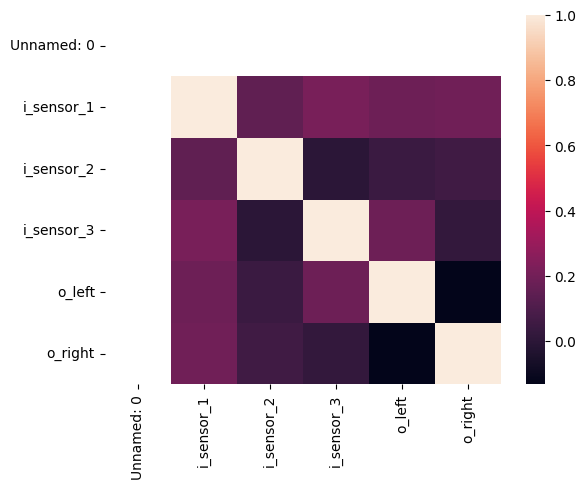

In [66]:
import seaborn as sns
sns.heatmap(df.corr())

# Scale/convert input values

In [67]:
df = df.astype({'o_left': int, 'o_right': int})   

In [68]:
df.head()

,Unnamed: 0,i_sensor_1,i_sensor_2,i_sensor_3,o_left,o_right
0,0,-1,183,79,0,0
1,0,-1,173,79,0,0
2,0,-1,163,79,0,0
3,0,-1,153,79,0,0
4,0,-1,143,79,0,0


In [69]:
df[df['o_left']==1]

,Unnamed: 0,i_sensor_1,i_sensor_2,i_sensor_3,o_left,o_right
22,0,-1,167,66,1,0
23,0,-1,207,69,1,0
26,0,-1,120,73,1,0
45,0,-1,120,70,1,0
54,0,-1,119,72,1,0
...,...,...,...,...,...,...
2242,0,-1,91,264,1,0
2243,0,-1,84,265,1,0
2244,0,-1,79,267,1,0
2245,0,290,74,274,1,0


# Set Train and test 

In [70]:
from sklearn.model_selection import train_test_split
X = df.drop(['o_left','o_right','Unnamed: 0'],axis=1).values
y = df[['o_left','o_right']].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=101)

# Create neural network

In [71]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [72]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
model = Sequential()
X_train.shape

(1775, 3)

In [59]:
model.add(Dense(units=8, input_dim=3,activation='relu'))

model.add(Dense(units=20,activation='relu'))

model.add(Dense(units=20,activation='relu'))

model.add(Dense(units=20,activation='relu'))

model.add(Dense(2,activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model

In [60]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=120,
          validation_data=(X_test, y_test), verbose=1
          )

Epoch 1/120
93/93 [==============================] - 0s 2ms/step - loss: 0.9289 - accuracy: 0.6166 - val_loss: 0.3717 - val_accuracy: 0.6656
Epoch 2/120
93/93 [==============================] - 0s 997us/step - loss: 0.2974 - accuracy: 0.6112 - val_loss: 0.3041 - val_accuracy: 0.4614
Epoch 3/120
93/93 [==============================] - 0s 987us/step - loss: 0.2655 - accuracy: 0.5561 - val_loss: 0.3326 - val_accuracy: 0.3517
Epoch 4/120
93/93 [==============================] - 0s 1ms/step - loss: 0.2512 - accuracy: 0.5152 - val_loss: 0.2664 - val_accuracy: 0.6680
Epoch 5/120
93/93 [==============================] - 0s 984us/step - loss: 0.2408 - accuracy: 0.5534 - val_loss: 0.2748 - val_accuracy: 0.7303
Epoch 6/120
93/93 [==============================] - 0s 1ms/step - loss: 0.2601 - accuracy: 0.5375 - val_loss: 0.2886 - val_accuracy: 0.8013
Epoch 7/120
93/93 [==============================] - 0s 1ms/step - loss: 0.2427 - accuracy: 0.5436 - val_loss: 0.2728 - val_accuracy: 0.3320
Epoch 8

93/93 [==============================] - 0s 1ms/step - loss: 0.2117 - accuracy: 0.4040 - val_loss: 0.2297 - val_accuracy: 0.4377
Epoch 59/120
93/93 [==============================] - 0s 1ms/step - loss: 0.2097 - accuracy: 0.4260 - val_loss: 0.2330 - val_accuracy: 0.2965
Epoch 60/120
93/93 [==============================] - 0s 996us/step - loss: 0.2065 - accuracy: 0.4314 - val_loss: 0.2496 - val_accuracy: 0.4913
Epoch 61/120
93/93 [==============================] - 0s 984us/step - loss: 0.2103 - accuracy: 0.4168 - val_loss: 0.2574 - val_accuracy: 0.5568
Epoch 62/120
93/93 [==============================] - 0s 1ms/step - loss: 0.2111 - accuracy: 0.4182 - val_loss: 0.2394 - val_accuracy: 0.6017
Epoch 63/120
93/93 [==============================] - 0s 1ms/step - loss: 0.2082 - accuracy: 0.4216 - val_loss: 0.2263 - val_accuracy: 0.3959
Epoch 64/120
93/93 [==============================] - 0s 1ms/step - loss: 0.2099 - accuracy: 0.4287 - val_loss: 0.2238 - val_accuracy: 0.3502
Epoch 65/120
93

93/93 [==============================] - 0s 1ms/step - loss: 0.1999 - accuracy: 0.4162 - val_loss: 0.2276 - val_accuracy: 0.3975
Epoch 116/120
93/93 [==============================] - 0s 1ms/step - loss: 0.1975 - accuracy: 0.4131 - val_loss: 0.2222 - val_accuracy: 0.3162
Epoch 117/120
93/93 [==============================] - 0s 1ms/step - loss: 0.1987 - accuracy: 0.3925 - val_loss: 0.2203 - val_accuracy: 0.3360
Epoch 118/120
93/93 [==============================] - 0s 1ms/step - loss: 0.2015 - accuracy: 0.3908 - val_loss: 0.2213 - val_accuracy: 0.3312
Epoch 119/120
93/93 [==============================] - 0s 1ms/step - loss: 0.1983 - accuracy: 0.3891 - val_loss: 0.2210 - val_accuracy: 0.2555
Epoch 120/120
93/93 [==============================] - 0s 1ms/step - loss: 0.2006 - accuracy: 0.3874 - val_loss: 0.2192 - val_accuracy: 0.3407


In [61]:
model_loss = pd.DataFrame(model.history.history)

<AxesSubplot:>

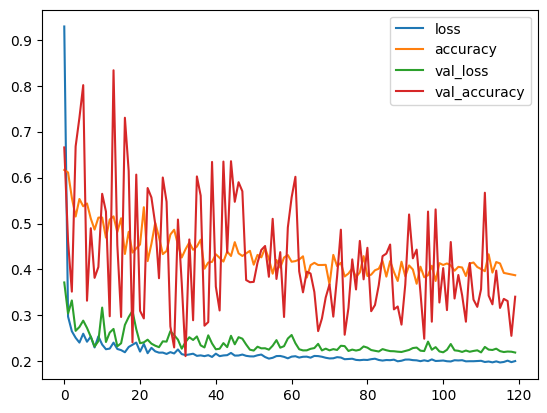

In [62]:
model_loss.plot()

In [54]:
model.save('car_game_model.h5')

In [55]:
import keras
model = keras.models.load_model('car_game_model.h5')

In [56]:
from car_game.car_game import CarGame
from car_game.road_enum import RoadEnum
    
car_game = CarGame(screen_size=(1600, 1200), car_speed=5, frame_rate=60,
                   road=RoadEnum.ONE, sensor_threshold=600, generate_train_data=False, nn_model=model)

car_game.start_game()


1/1 [==============================] - 0s 34ms/step
[[0.5455717  0.45442826]]
1/1 [==============================] - 0s 11ms/step
[[0.65707624 0.34292373]]
1/1 [==============================] - 0s 10ms/step
[[0.7544129  0.24558708]]
1/1 [==============================] - 0s 10ms/step
[[0.8161477  0.18385234]]
left
1/1 [==============================] - 0s 10ms/step
[[0.538247   0.46175298]]
1/1 [==============================] - 0s 10ms/step
[[0.50285804 0.49714202]]
1/1 [==============================] - 0s 10ms/step
[[0.5172125  0.48278752]]
1/1 [==============================] - 0s 11ms/step
[[0.50285804 0.49714202]]
1/1 [==============================] - 0s 10ms/step
[[0.49611816 0.5038819 ]]
1/1 [==============================] - 0s 10ms/step
[[0.4817644  0.51823556]]
1/1 [==============================] - 0s 10ms/step
[[0.3770559  0.62294406]]
1/1 [==============================] - 0s 10ms/step
[[0.24348716 0.7565129 ]]
1/1 [==============================] - 0s 10ms/step
[[0.460

1/1 [==============================] - 0s 10ms/step
[[0.1026901  0.89730984]]
right
1/1 [==============================] - 0s 10ms/step
[[0.50460196 0.49539798]]
1/1 [==============================] - 0s 10ms/step
[[0.5064005  0.49359944]]
1/1 [==============================] - 0s 10ms/step
[[0.09349173 0.90650827]]
right
1/1 [==============================] - 0s 10ms/step
[[0.06941236 0.9305876 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.04945586 0.9505441 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.13294819 0.8670518 ]]
right
1/1 [==============================] - 0s 9ms/step
[[0.23635954 0.76364046]]
1/1 [==============================] - 0s 10ms/step
[[0.23825775 0.76174223]]
1/1 [==============================] - 0s 10ms/step
[[0.06566449 0.9343355 ]]
right
1/1 [==============================] - 0s 10ms/step
[[0.38648576 0.6135143 ]]
1/1 [==============================] - 0s 10ms/step
[[0.13830386 0.8616962 ]]
right
1/1 [==================

1/1 [==============================] - 0s 10ms/step
[[0.7228882  0.27711192]]
1/1 [==============================] - 0s 10ms/step
[[0.7282818  0.27171823]]
1/1 [==============================] - 0s 10ms/step
[[0.75576025 0.24423975]]
1/1 [==============================] - 0s 10ms/step
[[0.79335344 0.20664655]]
1/1 [==============================] - 0s 10ms/step
[[0.817577 0.182423]]
left
1/1 [==============================] - 0s 10ms/step
[[0.7147116  0.28528842]]
1/1 [==============================] - 0s 10ms/step
[[0.7430784  0.25692156]]
1/1 [==============================] - 0s 10ms/step
[[0.8036011 0.1963989]]
left
1/1 [==============================] - 0s 10ms/step
[[0.9176389  0.08236111]]
left
1/1 [==============================] - 0s 10ms/step
[[0.6885551  0.31144482]]
1/1 [==============================] - 0s 10ms/step
[[0.71849865 0.2815014 ]]
1/1 [==============================] - 0s 10ms/step
[[0.78750443 0.21249558]]
1/1 [==============================] - 0s 10ms/step
[[0